# Bland-Altman analysis to compare segmentation algorithms
Assume we used a segmentation algorithm for many years and we are now considering to replace it by a newer, faster version. We need to make sure that we can compare results between these two. As segmentation algorithms typically do not label objects in the same order and even the number of objects might differ, we cannot easily compare objects pair-wise. It is recommended to summarize segmented objects per image and then compare results produced on folders of images.

In this notebook we will compare statistics derived from segmentation results produced by two algorithms on a folder of images. 

In [1]:
folder = '../../data/BBBC007_batch/' 

In [2]:
from skimage.io import imread
from skimage.measure import regionprops
from utils import bland_altman_plot
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import pyclesperanto_prototype as cle
import os
import numpy as np
import pandas as pd
import stackview

# Segmentation algorithms to compare
Here we write the two segmentation algorithms as Python functions and test them on an image.

StackViewNDArray([[3, 3, 3, ..., 2, 3, 3],
                  [5, 4, 4, ..., 3, 3, 2],
                  [6, 5, 4, ..., 2, 3, 2],
                  ...,
                  [2, 1, 1, ..., 1, 1, 1],
                  [1, 2, 2, ..., 2, 1, 1],
                  [2, 2, 1, ..., 1, 1, 1]], dtype=uint16)
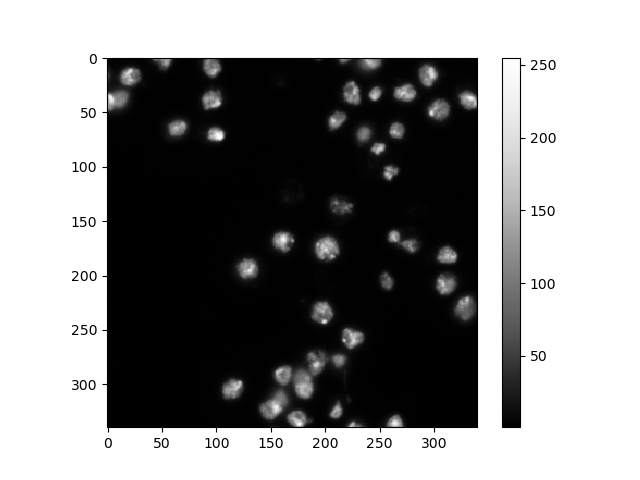
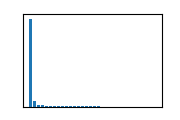

In [3]:
test_image = imread(folder + "17P1_POS0013_D_1UL.tif")
stackview.insight(test_image)

In [4]:
def segmentation_1(image):
    return nsbatwm.voronoi_otsu_labeling(image)

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]])
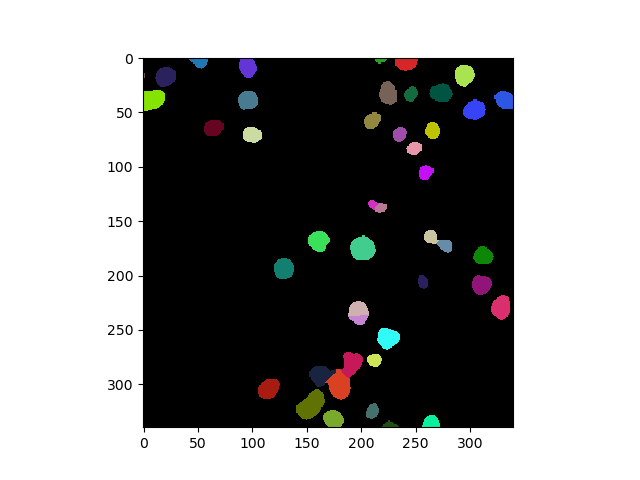

In [5]:
segmentation_1(test_image)

In [6]:
def segmentation_2(image):
    return nsbatwm.gauss_otsu_labeling(image)

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]])
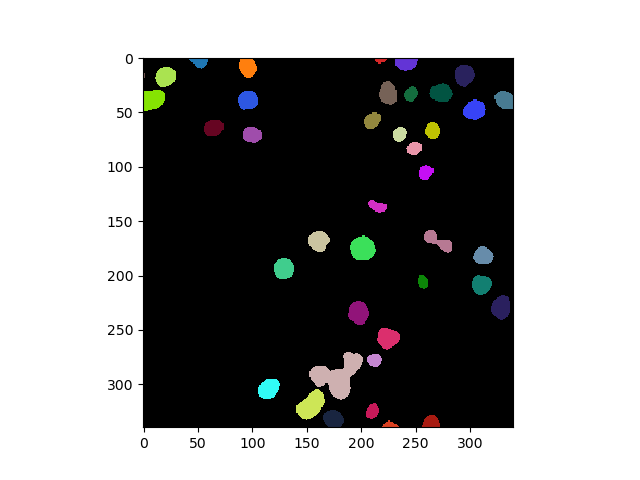

In [7]:
test_labels = segmentation_2(test_image)
test_labels

## Quantiative measurements
Later, we want to compare measurements. Thus, we write a Python function that determines these measurements. In this example, we will compute the mean area of segmented nuclei.

In [8]:
def mean_metric(image, label_image, metric):
    
    properties = regionprops(label_image, image)
    
    values = [p[metric] for p in properties]
    
    return np.mean(values)

In [9]:
mean_metric(test_image, test_labels, "area")

235.70731707317074

## Collecting measurements from folders
We now apply these two algorithms and the measurements in a folder of images.

In [10]:
def compare_measurements_from_algorithms(algorithm_1, algorithm_2, folder, metric):
    measurements = {
        metric + '_1':[],
        metric + '_2':[]
    }

    # Iterate over all files in the folder
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)

        # Check if the current item is a file
        if os.path.isfile(file_path) and filename.endswith(".tif"):
            # load image
            image = imread(file_path)

            # segment it using both algorithms
            labels_1 = algorithm_1(image)
            labels_2 = algorithm_2(image)

            # determine mean area and store it
            measurements[metric + '_1'].append(mean_metric(image, labels_1, metric))
            measurements[metric + '_2'].append(mean_metric(image, labels_2, metric))
    
    return measurements

In [11]:
measurements = compare_measurements_from_algorithms(segmentation_1, 
                                                    segmentation_2, 
                                                    folder, 
                                                    'area')

pd.DataFrame(measurements)

,area_1,area_2
0,210.086957,235.707317
1,206.866667,244.973684
2,203.023256,268.615385
3,185.103448,214.720000
4,184.147059,362.956522
5,267.057692,730.894737


## Bland-Altman plots
We now use the Bland-Altman plot to visualize differences.

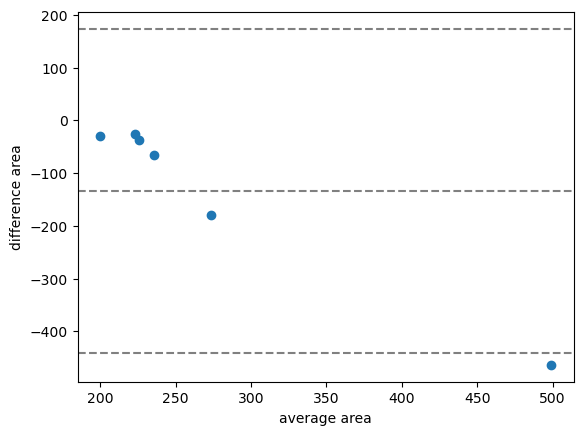

In [12]:
bland_altman_plot(measurements['area_1'], measurements['area_2'], 'area')

In the case shown above, the average difference of the area measurement is about -100, which means that the first algorithm produces on average smaller area measurements than the second.

For demonstration purposes we will now compare the same algorithm in a CPU and a GPU variant.

In [13]:
def segmentation_1_gpu(image):
    return cle.voronoi_otsu_labeling(image)

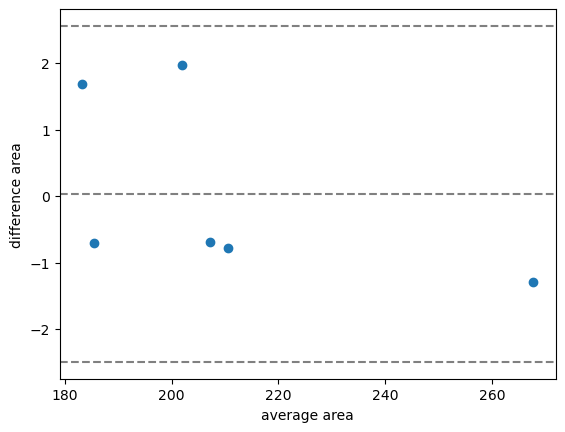

In [14]:
measurements_cpu_vs_gpu = compare_measurements_from_algorithms(segmentation_1, 
                                                    segmentation_1_gpu, 
                                                    folder, 
                                                    'area')
bland_altman_plot(measurements_cpu_vs_gpu['area_1'], measurements_cpu_vs_gpu['area_2'], 'area')

In this case, we see the average difference is about 0. Furthermore, the confidence interval is much smaller compared to before.

## Exercise
Also compare the second segmentation algorithm with its GPU-variant.

## Exercise

Compare mean intensity measurements of two algorithms where the area seems quite different. Can you predict how the Bland-Altman plot looks like?